# Exercise 7

<img src="./images/07.png" width=700>

**I have used Mosquito-on-human-skin instead of MNIST.**

- Step 1: Using NumPy's memmap functionality to write the Mosquito-on-human-skin dataset to disk.
- Step 2: Creating a MemmapedSimpleDataset that reads the mem-mapped files and generates PyTorch tensors in the __getitem__ method.
- Step 3: Explaining why this approach is useful.

### Step 1

In [ ]:
import numpy as np
from pathlib import Path


def imge_to_memmap(path: Path, mem_image_name: str, mem_label_name: str)-> None:
    class_name_labels = {cls_dir.name: cls for cls, cls_dir in enumerate(path.glob('*')) if cls_dir.is_dir()}
    num_image = len([1 for _ in path.rglob('*') if _.is_file()])
    image_shape = (224, 224, 3)
    memmap_images = np.memmap(f'{mem_image_name}.dat', dtype="float32", mode="w+", shape=(num_image,)+image_shape)
    memmap_labels = np.memmap(f'{mem_label_name}.dat', dtype="int64", mode="w+", shape=(num_image,))
    for idx, image_path in enumerate(path.rglob('*.jpg')):
        label = class_name_labels[image_path.parent.name]
        img = Image.open(image_path).convert('RGB')
        img_array = np.array(img)
        memmap_images[idx] = img_array
        memmap_labels[idx] = label
        if idx % 500 == 0 and idx:
            print(f'{idx} images are processed')

    memmap_images.flush()
    memmap_labels.flush()
    del memmap_images
    del memmap_labels
    print(f'All images:{num_image} images are processed')
    print('Done')

In [ ]:
path = Path('./data_splitting/Train')
imge_to_memmap(path, 'train_images', 'train_labels')

500 images are processed
1000 images are processed
1500 images are processed
2000 images are processed
2500 images are processed
3000 images are processed
3500 images are processed
4000 images are processed
All images:4200 images are processed
Done


### Step 2

4200
tensor(0)


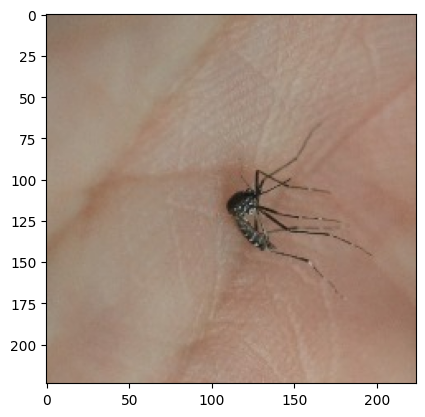

In [ ]:
import torch
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torchvision import transforms


class MemMosquitoDataset(Dataset):
    def __init__(self, mem_images, mem_labels):
        self.mem_labels = np.memmap(mem_labels, dtype=np.int64, mode='r')
        self.mem_images = np.memmap(mem_images, dtype=np.float32, mode='r', shape=(len(self.mem_labels), 224, 224, 3))
        # The np.memmap function creates a memory-mapped object. 
        # This object behaves like a NumPy array but accesses data directly from the file on disk.
    def __len__(self):
        return len(self.mem_labels)

    def __getitem__(self, idx):
        image = self.mem_images[idx] / 255
        label = self.mem_labels[idx]
        image = transforms.ToTensor()(image)
        label = torch.tensor(label, dtype=torch.int64)
        return image, label


train_dataset = MemMosquitoDataset('./train_images.dat', './train_labels.dat')
print(len(train_dataset))

# idx = 500
image_tensor, label_tensor = train_dataset[0]

print(label_tensor)
plt.imshow(image_tensor.permute(1, 2, 0))

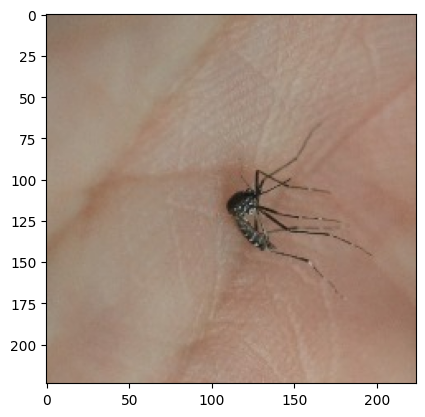

In [ ]:
mem_images = np.memmap('./train_images.dat', dtype=np.float32, mode='r', shape=(4200, 224, 224, 3))
# print(mem_images[0])
plt.imshow(mem_images[0]/255)


### Step 3: Why Is This Useful?

#### Benefits of Using Mem-mapped Files

1. Memory Efficiency: Memory mapping allows you to work with datasets larger than your RAM. Data is loaded into memory only when needed and can be accessed in small chunks.

2. Fast Random Access: Since data is stored on disk in a binary format, you can access any part of the dataset quickly without loading the entire file into memory.

3. Low Memory Footprint: This approach minimizes the memory footprint of your program, as it avoids loading the entire dataset into memory.

#### Use Case Scenarios

- Large Datasets: When dealing with very large datasets (e.g., high-resolution images, long time-series data) that cannot fit into memory.

- Distributed Systems: In multi-processing or distributed training setups, mem-mapped files can be shared across processes with minimal overhead.

- Resource-Constrained Environments: Useful when working on machines with limited RAM but sufficient disk space.

#### Comparison with Standard Loading

- Standard Loading: Loading the entire dataset into memory can be impractical for large datasets, causing memory exhaustion.

- Mem-mapped Loading: Only the required data slices are loaded into memory during an iteration, making it scalable and efficient.